In [1]:
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from random import shuffle, choices
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    hamming_loss,
)

# VIDEO PART

In [2]:
from GRU_pipeline import DataHolder, paths, dicDataset, GRUModel, pad_collate
from models import VideoGRU

AUDIO = False
VIDEO = True

DH = DataHolder(**paths)
if AUDIO:
    model = GRUModel(input_dim = 23) #17 for openface, 23 for opensmile
elif VIDEO:
    model = GRUModel(input_dim = 17)
else:
    print("error no feature specified")

In [3]:
train_test_1 = DH.stratified_train_test_split(feature = 'openface', speaker = 1, none_count = 800, test_size = .15, val_size = .17)
train_test_2 = DH.stratified_train_test_split(feature = 'openface', speaker = 2, none_count = 800, test_size = .15, val_size = .17)

class_weights = train_test_1['class_weights']
class_weights = torch.Tensor([(1 - x)**5 for x in class_weights])

train_dataset_1 = dicDataset(**train_test_1['data'])
test_dataset_1 = dicDataset(train_dic = train_test_1["data"]["test_dic"], features = train_test_1["data"]["features"], targets = train_test_1["data"]["targets"], test_dic = None)
val_dataset_1 = dicDataset(train_dic = train_test_1["data"]["valid_dic"], features = train_test_1["data"]["features"], targets = train_test_1["data"]["targets"], test_dic = None)

train_loader_1 = DataLoader(train_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)
val_loader_1 = DataLoader(val_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)
test_loader_1 = DataLoader(test_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)

train_dataset_2 = dicDataset(**train_test_2['data'])
test_dataset_2 = dicDataset(train_dic = train_test_2["data"]["test_dic"], features = train_test_2["data"]["features"], targets = train_test_2["data"]["targets"], test_dic = None)
val_dataset_2 = dicDataset(train_dic = train_test_2["data"]["valid_dic"], features = train_test_2["data"]["features"], targets = train_test_2["data"]["targets"], test_dic = None)

train_loader_2 = DataLoader(train_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)
val_loader_2 = DataLoader(val_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)
test_loader_2 = DataLoader(test_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)

In [4]:
def eval_on_val():
    model.eval()
    tot_loss=0.0
    for i, batch in enumerate(val_loader_1):
        features, targets = batch['features'], batch['targets']
        with torch.no_grad():
            pred = model(features)
            loss = criterion(pred, targets)
            tot_loss += loss / pred.shape[0]
    for i, batch in enumerate(val_loader_2):
        features, targets = batch['features'], batch['targets']
        with torch.no_grad():
            pred = model(features)
            loss = criterion(pred, targets)
            tot_loss += loss / pred.shape[0]
    return loss

hist_train_loss = []
hist_test_loss = []

def train_one_epoch(epoch, dataloader_1, dataloader_2, hist_train_loss, hist_val_loss):

    model.train()

    epoch_loss = 0.0

    for i, batch in enumerate(dataloader_1):
        features, targets = batch['features'], batch['targets']
        pred = model(features)
        loss = criterion(pred, targets)

        epoch_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for i, batch in enumerate(dataloader_2):
        features, targets = batch['features'], batch['targets']
        pred = model(features)
        loss = criterion(pred, targets)

        epoch_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    hist_train_loss = hist_train_loss + [loss]
    val_loss = eval_on_val()
    hist_val_loss = hist_val_loss + [val_loss]
    if epoch % 50 == 0:
        tqdm.write(f"================\nTraining epoch {epoch} :\nTrain loss = {loss}, Val loss = {val_loss}\n================")
    return hist_train_loss, hist_val_loss

In [5]:
model = GRUModel(input_dim=17, hidden_dim = 32) #, hidden_dim = 128, hidden_dim2 = 128, layer_dim = 2, output_dim = 5) #17 for openface, 23 for opensmile
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)



criterion = nn.KLDivLoss() # weight = class_weights

### Find the way to magnify negative examples using negative loss on them (not weighted)
# Triplet Loss
# Contrastive loss

Gather the negative examples yielding the highest prediction probability class-wise and use them as negatve examples

# 1. USE OF NEGATIVE EXAMPLES WITH AFOREMENTIONED LOSSES
# 2. MOVE ON TOWARDS MULTI MODALITY

In [18]:
from IPython.display import clear_output

#hist_train_loss, hist_test_loss, hist_val_loss = [], [], []
for epoch in tqdm(range(200)):
    curr_train_loss, curr_test_loss = hist_train_loss, hist_val_loss
    
    hist_train_loss, hist_val_loss = train_one_epoch(epoch, train_loader_1, train_loader_2, curr_train_loss, curr_test_loss)
hist_train_loss = [x if type(x)==np.ndarray else x.detach().numpy()  for x in hist_train_loss]
hist_val_loss = [x if type(x)==np.ndarray else x.detach().numpy()  for x in hist_val_loss]

  0%|          | 0/200 [00:00<?, ?it/s]/Users/tancredeasselot/miniconda/envs/projet_ewen/lib/python3.10/site-packages/torch/nn/functional.py:2918: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
  0%|          | 1/200 [00:00<02:42,  1.23it/s]

Training epoch 0 :
Train loss = -0.07186576724052429, Val loss = -0.07121387869119644


 26%|██▌       | 51/200 [00:38<01:50,  1.35it/s]

Training epoch 50 :
Train loss = -0.06599777936935425, Val loss = -0.07255183160305023


 50%|█████     | 101/200 [01:15<01:20,  1.22it/s]

Training epoch 100 :
Train loss = -0.08157110959291458, Val loss = -0.07364924252033234


 76%|███████▌  | 151/200 [01:49<00:30,  1.59it/s]

Training epoch 150 :
Train loss = -0.06957649439573288, Val loss = -0.07458273321390152


100%|██████████| 200/200 [02:20<00:00,  1.42it/s]


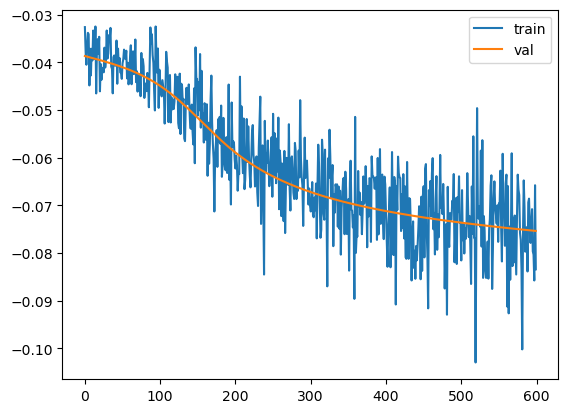

In [19]:
plt.plot(hist_train_loss, label='train')
plt.plot(hist_val_loss, label='val')
plt.legend()
plt.show()

# Part on evaluation of the model

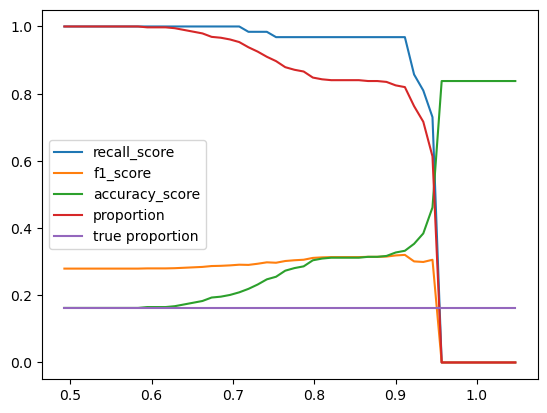

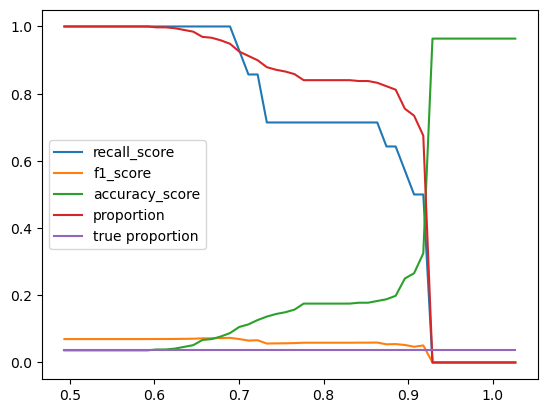

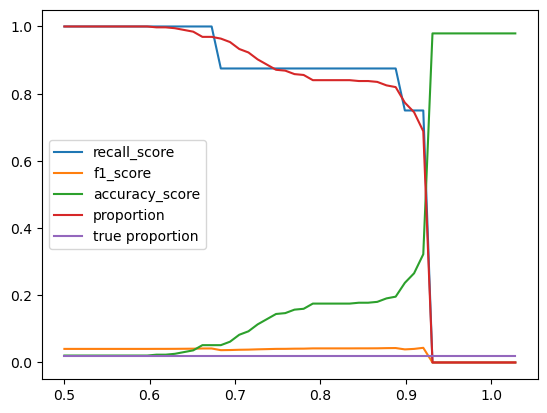

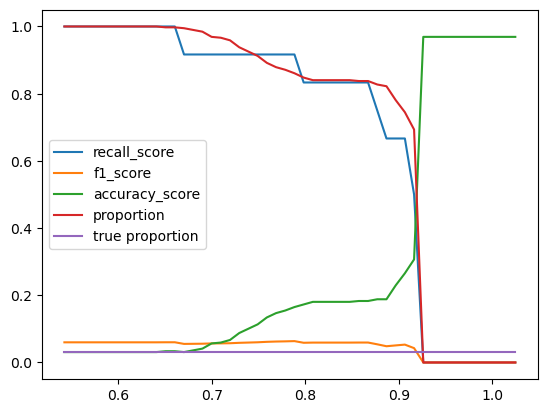

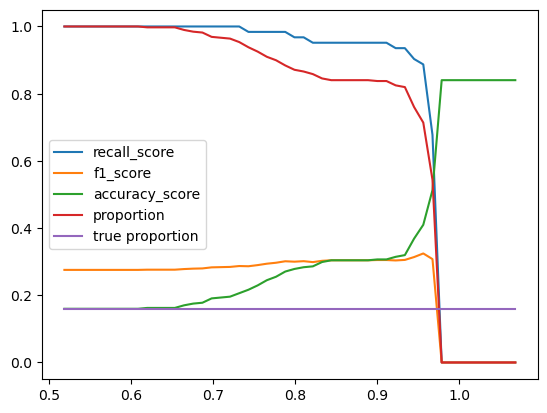

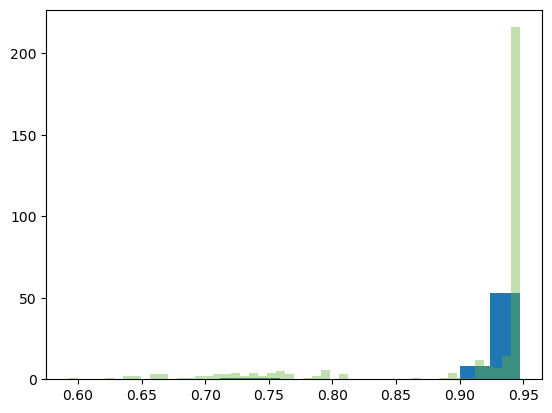

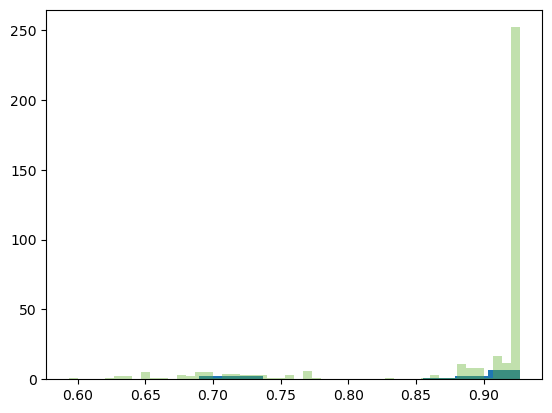

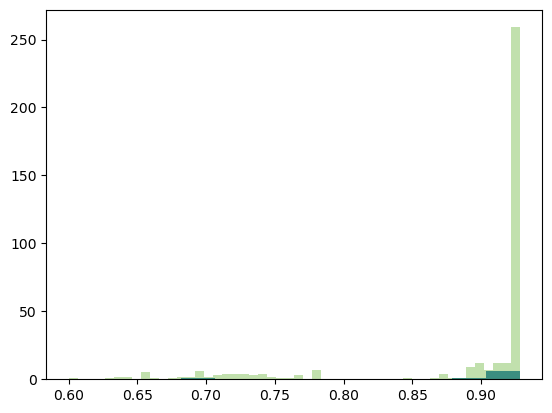

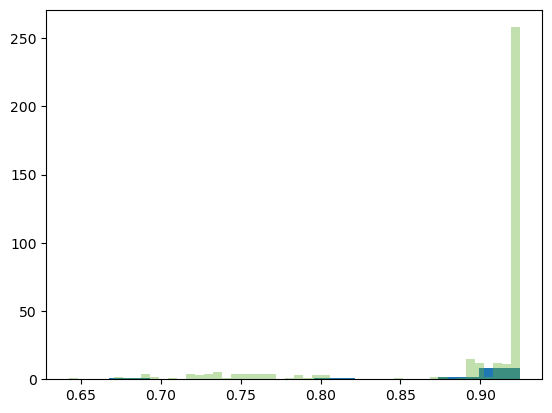

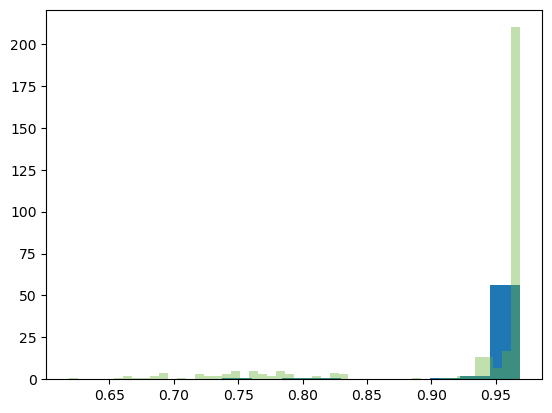

In [20]:
y_test_1 = train_dataset_1.get_test()
y_test_2 = train_dataset_2.get_test()

y_true = np.concatenate([y_test_1["targets"], y_test_2["targets"]])

pred_1 = model(y_test_1['features']).detach().numpy()
pred_2 = model(y_test_2['features']).detach().numpy()

pred_n = np.concatenate([pred_1, pred_2])


def explore_tresh(true, pred):
    tresh = np.linspace(pred.min()-.1,pred.max()+.1,50)
    out = [(
        # precision_score(true, np.where(pred>t,1,0)),
        recall_score(true, np.where(pred>t,1,0)),
        f1_score(true, np.where(pred>t,1,0)),
        accuracy_score(true, np.where(pred>t, 1, 0)),
        np.where(pred>t,1,0).sum() / pred.shape[0],
        true.sum()/true.shape[0]
    ) for t in tresh]
    out = pd.DataFrame(out, columns=['recall_score', 'f1_score', 'accuracy_score', 'proportion', 'true proportion'], index=tresh) #'precision_score',
    return out

df_pred = pd.DataFrame(pred_n, columns = ['SD', 'QE', 'SV', 'PR', 'HD'])
df_true = pd.DataFrame(y_true, columns = ['SD', 'QE', 'SV', 'PR', 'HD'])
for i in range(5):
    explore_tresh(y_true[:,i], pred_n[:,i]).plot()

plt.figure()
plt.hist(df_pred.SD.loc[df_true.SD==1])
plt.hist(df_pred.SD.loc[df_true.SD==0], bins = 50, fc = (.4, .7, .2, .4))
plt.show()
plt.hist(df_pred.QE.loc[df_true.QE==1])
plt.hist(df_pred.QE.loc[df_true.QE==0], bins = 50, fc = (.4, .7, .2, .4))
plt.show()
plt.hist(df_pred.SV.loc[df_true.SV==1])
plt.hist(df_pred.SV.loc[df_true.SV==0], bins = 50, fc = (.4, .7, .2, .4))
plt.show()
plt.hist(df_pred.PR.loc[df_true.PR==1])
plt.hist(df_pred.PR.loc[df_true.PR==0], bins = 50, fc = (.4, .7, .2, .4))
plt.show()
plt.hist(df_pred.HD.loc[df_true.HD==1])
plt.hist(df_pred.HD.loc[df_true.HD==0], bins = 50, fc = (.4, .7, .2, .4))
plt.show()

# AUDIO PART

In [15]:
from GRU_pipeline import DataHolder, paths, dicDataset, GRUModel, pad_collate
from models import VideoGRU

DH = DataHolder(**paths)
audio_model = GRUModel(input_dim = 23) #17 for openface, 23 for opensmile

In [16]:
train_test_1 = DH.stratified_train_test_split(feature = 'opensmile', speaker = 1, none_count = 800, test_size = .15, val_size = .17)
train_test_2 = DH.stratified_train_test_split(feature = 'opensmile', speaker = 2, none_count = 800, test_size = .15, val_size = .17)

class_weights = train_test_1['class_weights']
class_weights = torch.Tensor([(1 - x)**5 for x in class_weights])

train_dataset_1 = dicDataset(**train_test_1['data'])
test_dataset_1 = dicDataset(train_dic = train_test_1["data"]["test_dic"], features = train_test_1["data"]["features"], targets = train_test_1["data"]["targets"], test_dic = None)
val_dataset_1 = dicDataset(train_dic = train_test_1["data"]["valid_dic"], features = train_test_1["data"]["features"], targets = train_test_1["data"]["targets"], test_dic = None)

train_loader_1 = DataLoader(train_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)
val_loader_1 = DataLoader(val_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)
test_loader_1 = DataLoader(test_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)

train_dataset_2 = dicDataset(**train_test_2['data'])
test_dataset_2 = dicDataset(train_dic = train_test_2["data"]["test_dic"], features = train_test_2["data"]["features"], targets = train_test_2["data"]["targets"], test_dic = None)
val_dataset_2 = dicDataset(train_dic = train_test_2["data"]["valid_dic"], features = train_test_2["data"]["features"], targets = train_test_2["data"]["targets"], test_dic = None)

train_loader_2 = DataLoader(train_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)
val_loader_2 = DataLoader(val_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)
test_loader_2 = DataLoader(test_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)

In [17]:
def eval_on_val():
    audio_model.eval()
    tot_loss=0.0
    for i, batch in enumerate(val_loader_1):
        features, targets = batch['features'], batch['targets']
        with torch.no_grad():
            pred = audio_model(features)
            loss = criterion(pred, targets)
            tot_loss += loss / pred.shape[0]
    for i, batch in enumerate(val_loader_2):
        features, targets = batch['features'], batch['targets']
        with torch.no_grad():
            pred = audio_model(features)
            loss = criterion(pred, targets)
            tot_loss += loss / pred.shape[0]
    return loss

hist_train_loss = []
hist_test_loss = []

def train_one_epoch(epoch, dataloader_1, dataloader_2, hist_train_loss, hist_val_loss):

    audio_model.train()

    epoch_loss = 0.0

    for i, batch in enumerate(dataloader_1):
        features, targets = batch['features'], batch['targets']
        pred = audio_model(features)
        loss = criterion(pred, targets)

        epoch_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for i, batch in enumerate(dataloader_2):
        features, targets = batch['features'], batch['targets']
        pred = audio_model(features)
        loss = criterion(pred, targets)

        epoch_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    hist_train_loss = hist_train_loss + [loss]
    val_loss = eval_on_val()
    hist_val_loss = hist_val_loss + [val_loss]
    if epoch % 50 == 0:
        tqdm.write(f"================\nTraining epoch {epoch} :\nTrain loss = {loss}, Val loss = {val_loss}\n================")
    return hist_train_loss, hist_val_loss

In [18]:
audio_model = GRUModel(input_dim = 23, hidden_dim = 32) #, hidden_dim = 128, hidden_dim2 = 128, layer_dim = 2, output_dim = 5) #17 for openface, 23 for opensmile
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
criterion = nn.KLDivLoss() #weight = class_weights

In [19]:
from IPython.display import clear_output

hist_train_loss, hist_test_loss, hist_val_loss = [], [], []
for epoch in tqdm(range(200)):
    curr_train_loss, curr_test_loss = hist_train_loss, hist_val_loss
    
    hist_train_loss, hist_val_loss = train_one_epoch(epoch, train_loader_1, train_loader_2, curr_train_loss, curr_test_loss)
hist_train_loss = [x.detach().numpy() for x in hist_train_loss]
hist_val_loss = [x.detach().numpy() for x in hist_val_loss]

  0%|          | 0/200 [00:00<?, ?it/s]/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/torch/nn/functional.py:2916: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
  0%|          | 1/200 [00:00<03:12,  1.03it/s]

Training epoch 0 :
Train loss = -0.028490835800766945, Val loss = -0.037874381989240646


 26%|██▌       | 51/200 [00:47<02:05,  1.19it/s]

Training epoch 50 :
Train loss = -0.03886876255273819, Val loss = -0.03787437826395035


 50%|█████     | 101/200 [01:30<01:21,  1.21it/s]

Training epoch 100 :
Train loss = -0.04148157313466072, Val loss = -0.03787437826395035


 76%|███████▌  | 151/200 [02:14<00:42,  1.15it/s]

Training epoch 150 :
Train loss = -0.03860465809702873, Val loss = -0.03787437826395035


100%|██████████| 200/200 [02:55<00:00,  1.14it/s]


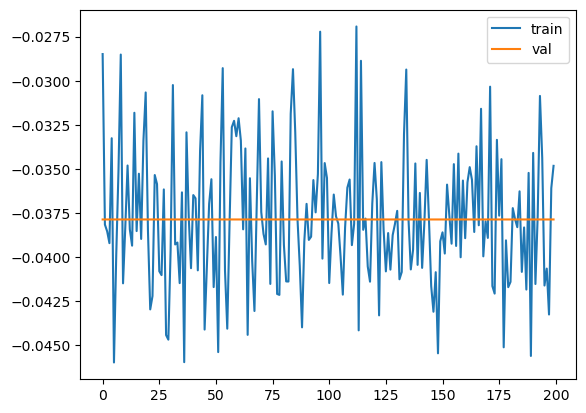

In [20]:
plt.plot(hist_train_loss, label='train')
plt.plot(hist_val_loss, label='val')
plt.legend()
plt.show()

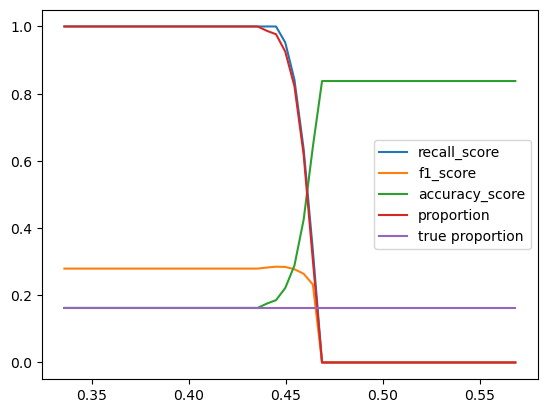

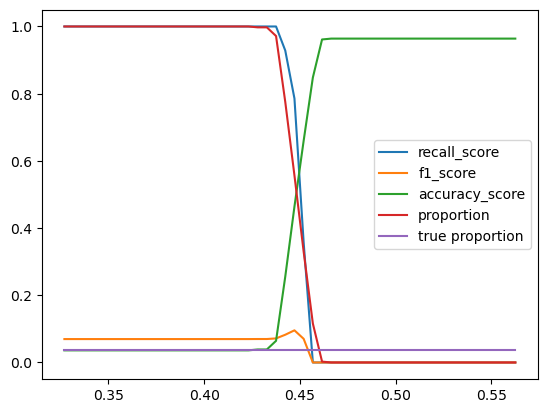

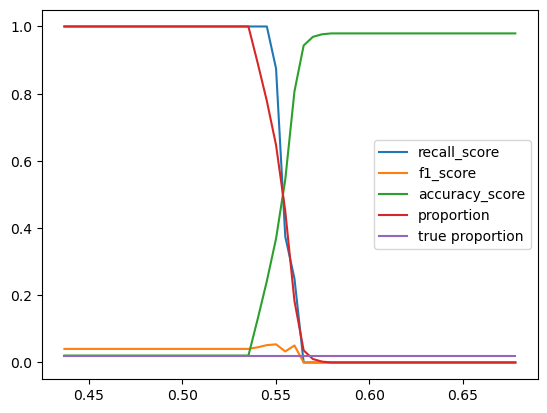

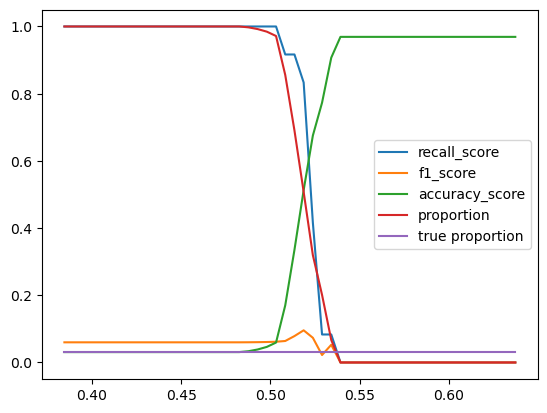

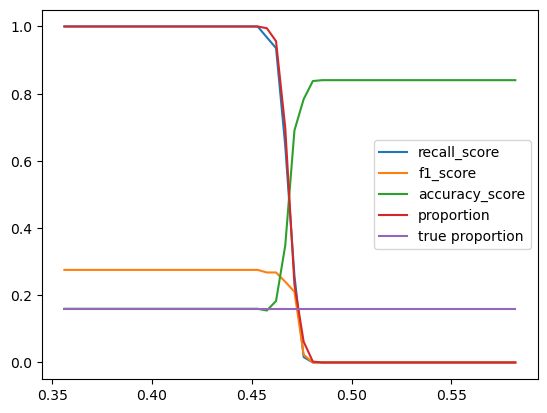

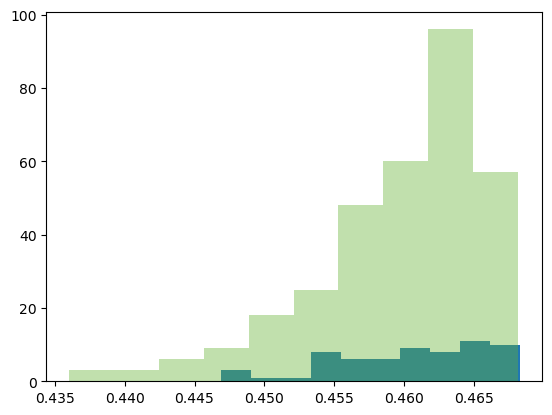

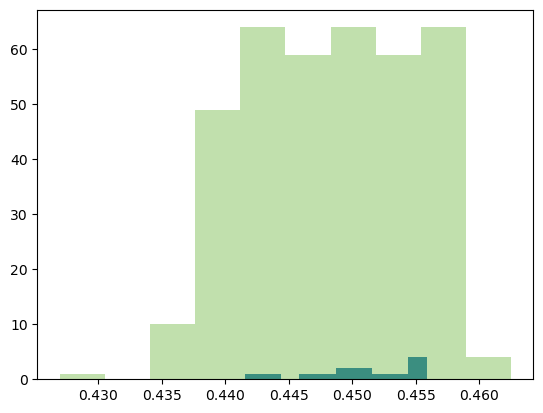

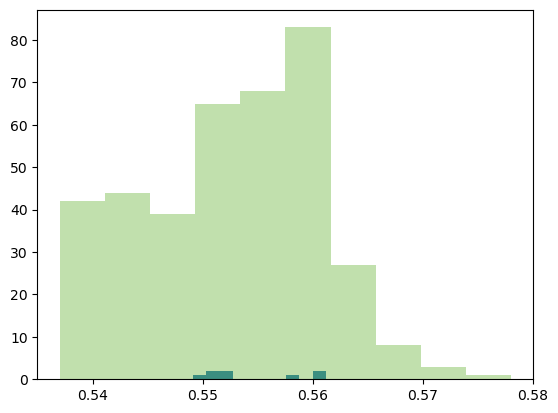

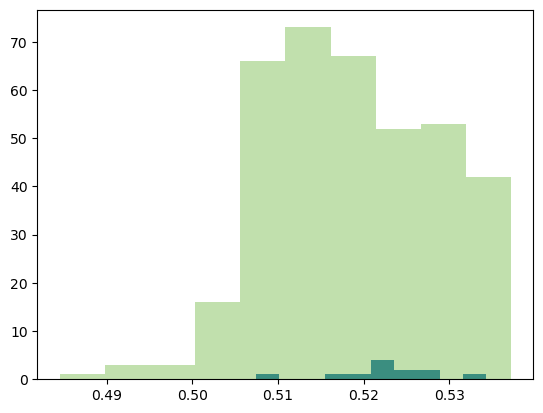

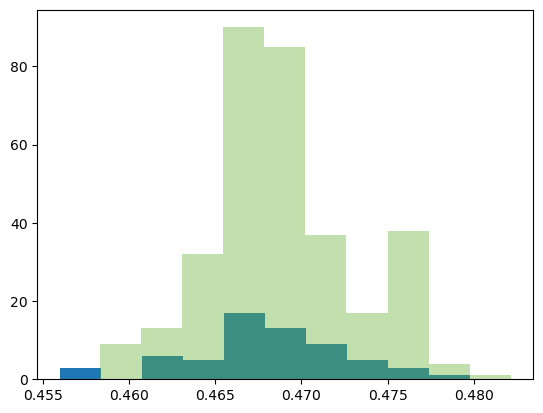

In [23]:
y_test_1 = train_dataset_1.get_test()
y_test_2 = train_dataset_2.get_test()

y_true = np.concatenate([y_test_1["targets"], y_test_2["targets"]])

pred_1 = audio_model(y_test_1['features']).detach().numpy()
pred_2 = audio_model(y_test_2['features']).detach().numpy()

pred_n = np.concatenate([pred_1, pred_2])

df_true = pd.DataFrame(y_true, columns = ['SD', 'QE', 'SV', 'PR', 'HD'])

def explore_tresh(true, pred):
    tresh = np.linspace(pred.min()-.1,pred.max()+.1,50)
    
    out = [(
        # precision_score(true, np.where(pred>t,1,0)),
        recall_score(true, np.where(pred>t,1,0)),
        f1_score(true, np.where(pred>t,1,0)),
        accuracy_score(true, np.where(pred>t, 1, 0)),
        np.where(pred>t,1,0).sum() / pred.shape[0],
        true.sum()/true.shape[0]
    ) for t in tresh]
    
    out = pd.DataFrame(out, columns=['recall_score', 'f1_score', 'accuracy_score', 'proportion', 'true proportion'], index=tresh) #'precision_score',
    return out
df_pred = pd.DataFrame(pred_n, columns = ['SD', 'QE', 'SV', 'PR', 'HD'])

for i in range(5):
    explore_tresh(y_true[:,i], pred_n[:,i]).plot()

plt.figure()
plt.hist(df_pred.SD.loc[df_true.SD==1])
plt.hist(df_pred.SD.loc[df_true.SD==0], fc = (.4, .7, .2, .4))
plt.show()
plt.hist(df_pred.QE.loc[df_true.QE==1])
plt.hist(df_pred.QE.loc[df_true.QE==0], fc = (.4, .7, .2, .4))
plt.show()
plt.hist(df_pred.SV.loc[df_true.SV==1])
plt.hist(df_pred.SV.loc[df_true.SV==0], fc = (.4, .7, .2, .4))
plt.show()
plt.hist(df_pred.PR.loc[df_true.PR==1])
plt.hist(df_pred.PR.loc[df_true.PR==0], fc = (.4, .7, .2, .4))
plt.show()
plt.hist(df_pred.HD.loc[df_true.HD==1])
plt.hist(df_pred.HD.loc[df_true.HD==0], fc = (.4, .7, .2, .4))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
df_pred = HD.embds
# plt.hist(

In [107]:
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    hamming_loss,
)

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(len(y_true)):
        set_true = set(np.where(y_true[i])[0])
        set_pred = set(np.where(y_pred[i])[0])

        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred)) / float(
                len(set_true.union(set_pred))
            )
        acc_list.append(tmp_a)

    return np.mean(acc_list)

In [33]:
model.eval()
fin_targets = []
fin_outputs = []

for j, data in tqdm(enumerate(test_loader)):
    features, targets = data['features'], data['targets']

    pred = torch.nn.Sigmoid()(model(features))
    loss = criterion(pred, targets)

    fin_targets.extend(targets.cpu().detach().numpy().tolist())
    fin_outputs.extend((np.array(pred.cpu().detach().numpy()) >= .3).tolist())
    if j%5 == 0:
        print("outputs: ")
        print(pred)
        print("fin_outputs")
        print(fin_outputs)
        print("fin_targets")
        print(fin_targets)
    val_hamming_loss = hamming_loss(fin_targets, fin_outputs)
    val_hamming_score = hamming_score(fin_targets, fin_outputs)

    cpu_y = np.where(
        fin_targets == False,
        0,
        np.where(fin_targets == True, 1, np.array(fin_targets)),
    )
    cpu_y_hat = np.where(
        fin_targets == False,
        0,
        np.where(fin_targets == True, 1, np.array(fin_outputs)),
    )
    print(cpu_y_hat)
    cpu_y = cpu_y.reshape(cpu_y_hat.shape)
    results = {}
    f_score_tot_none = f1_score(cpu_y, cpu_y_hat, average=None)
    f_score_tot_micro = f1_score(cpu_y, cpu_y_hat, average="micro")
    f_score_tot_macro = f1_score(cpu_y, cpu_y_hat, average="macro")
    f_score_tot_weighted = f1_score(cpu_y, cpu_y_hat, average="weighted")

    class_list = DH.target_col

for j, c in enumerate(class_list):
    print(
        f"Total label for {c} : {np.sum(cpu_y[:, j])}, number of correct pred {np.dot(cpu_y[:, j], cpu_y_hat[:, j])}"
    )
    label_y = cpu_y[:, j]
    label_pred = cpu_y_hat[:, j]
    rec = recall_score(label_y, label_pred)
    prec = precision_score(label_y, label_pred)
    acc = accuracy_score(label_y, label_pred)

    try:
        auc = roc_auc_score(label_y, label_pred)
    except ValueError:
        auc = 1

    results[c] = {
        "Recall": f"{rec:.4f}",
        "Precision": f"{prec:.4f}",
        "Accuracy": f"{acc:.2f}",
    }

print(f"Hamming Score for {type(model).__name__} = ", val_hamming_score)
print(f"Hamming Loss for {type(model).__name__} = ", val_hamming_loss)
with open("models/results.txt", "a") as f:
    f.write("=========================\n")
    f.write(f"EVALUATING {type(model).__name__}\n")
    f.write("=========================\n")
    for k_ in results.keys():
        f.write(str(k_) + str(results[k_]) + "\n")
    f.write("Total f1 score : {}\n".format(f_score_tot_none))
    f.write("Total f1 score micro : {}\n".format(f_score_tot_micro))
    f.write("Total f1 score macro : {}\n".format(f_score_tot_macro))
    f.write("Total f1 score weighted : {}\n".format(f_score_tot_weighted))

1it [00:00,  2.33it/s]

outputs: 
tensor([[0.1513, 0.0230, 0.0181, 0.0076, 0.1265],
        [0.1544, 0.0228, 0.0182, 0.0076, 0.1278],
        [0.2181, 0.0705, 0.0601, 0.0349, 0.1884],
        [0.1578, 0.0275, 0.0219, 0.0099, 0.1267],
        [0.1275, 0.0117, 0.0091, 0.0031, 0.1048],
        [0.1327, 0.0112, 0.0081, 0.0028, 0.1008],
        [0.2621, 0.1195, 0.0993, 0.0729, 0.2189],
        [0.1471, 0.0234, 0.0179, 0.0081, 0.1149],
        [0.1914, 0.0392, 0.0339, 0.0147, 0.1793],
        [0.1223, 0.0107, 0.0078, 0.0027, 0.0979],
        [0.1139, 0.0097, 0.0070, 0.0025, 0.0860],
        [0.1519, 0.0218, 0.0177, 0.0072, 0.1335],
        [0.1525, 0.0212, 0.0168, 0.0069, 0.1244],
        [0.1196, 0.0105, 0.0076, 0.0027, 0.0924],
        [0.1978, 0.0478, 0.0404, 0.0200, 0.1744],
        [0.3532, 0.2435, 0.2206, 0.1899, 0.3137],
        [0.1257, 0.0108, 0.0078, 0.0027, 0.0949],
        [0.2343, 0.0906, 0.0736, 0.0496, 0.1906],
        [0.1166, 0.0107, 0.0078, 0.0028, 0.0885],
        [0.1581, 0.0227, 0.0182, 0.0076,


/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
model.eval()
for j, data in tqdm(enumerate(test_loader)):
    features, targets = data['features'], data['targets']
    pred = model(features)
    print(pred)
    
    fin_targets.extend(targets.cpu().detach().numpy().tolist())
    fin_outputs.extend((np.array(pred.cpu().detach().numpy()) >= .3).tolist())

    cpu_y = np.where(
        fin_targets == False,
        0,
        np.where(fin_targets == True, 1, np.array(fin_targets)),
    )
    cpu_y_hat = np.where(
        fin_targets == False,
        0,
        np.where(fin_targets == True, 1, np.array(fin_outputs)),
    )
    cpu_y = cpu_y.reshape(cpu_y_hat.shape)
    results = {}
    f_score_tot_none = f1_score(cpu_y, cpu_y_hat, average=None)
    f_score_tot_micro = f1_score(cpu_y, cpu_y_hat, average="micro")
    f_score_tot_macro = f1_score(cpu_y, cpu_y_hat, average="macro")
    f_score_tot_weighted = f1_score(cpu_y, cpu_y_hat, average="weighted")

2it [00:00,  5.14it/s]

tensor([[1.0000e+00, 1.7075e-06, 1.0072e-06, 7.5992e-07, 1.0000e+00],
        [1.0000e+00, 2.0108e-06, 1.1965e-06, 9.1384e-07, 1.0000e+00],
        [1.0000e+00, 1.6426e-06, 9.6638e-07, 7.2778e-07, 1.0000e+00],
        [1.0000e+00, 2.0649e-06, 1.2336e-06, 9.4719e-07, 1.0000e+00],
        [9.9996e-01, 8.3359e-05, 5.9957e-05, 5.1650e-05, 9.9986e-01],
        [1.0000e+00, 1.6423e-06, 9.6674e-07, 7.2603e-07, 1.0000e+00],
        [1.0000e+00, 2.1072e-06, 1.2574e-06, 9.6372e-07, 1.0000e+00],
        [9.9999e-01, 1.7586e-05, 1.1308e-05, 9.4599e-06, 9.9997e-01],
        [1.0000e+00, 1.8707e-06, 1.1109e-06, 8.4767e-07, 1.0000e+00],
        [1.0000e+00, 1.6200e-06, 9.5265e-07, 7.1497e-07, 1.0000e+00],
        [1.0000e+00, 1.6315e-06, 9.5963e-07, 7.2150e-07, 1.0000e+00],
        [1.0000e+00, 1.6292e-06, 9.5812e-07, 7.2013e-07, 1.0000e+00],
        [1.0000e+00, 1.6996e-06, 1.0026e-06, 7.5803e-07, 1.0000e+00],
        [1.0000e+00, 1.6650e-06, 9.8193e-07, 7.3872e-07, 1.0000e+00],
        [1.0000e+00,

3it [00:00,  5.50it/s]

tensor([[1.0000e+00, 3.5548e-06, 2.1900e-06, 1.7181e-06, 9.9999e-01],
        [1.0000e+00, 1.7035e-06, 1.0053e-06, 7.5924e-07, 1.0000e+00],
        [1.0000e+00, 1.6285e-06, 9.5794e-07, 7.1976e-07, 1.0000e+00],
        [1.0000e+00, 1.6330e-06, 9.6084e-07, 7.2212e-07, 1.0000e+00],
        [1.0000e+00, 1.6648e-06, 9.8092e-07, 7.3890e-07, 1.0000e+00],
        [1.0000e+00, 1.6320e-06, 9.6006e-07, 7.2156e-07, 1.0000e+00],
        [1.0000e+00, 4.4092e-06, 2.7533e-06, 2.1727e-06, 9.9999e-01],
        [1.0000e+00, 1.7115e-06, 1.0102e-06, 7.6335e-07, 1.0000e+00],
        [1.0000e+00, 1.6280e-06, 9.5745e-07, 7.1960e-07, 1.0000e+00],
        [1.0000e+00, 1.7734e-06, 1.0494e-06, 7.9420e-07, 1.0000e+00],
        [1.0000e+00, 2.1897e-06, 1.3126e-06, 1.0117e-06, 1.0000e+00],
        [1.0000e+00, 1.6576e-06, 9.7628e-07, 7.3546e-07, 1.0000e+00],
        [1.0000e+00, 1.0580e-05, 6.6691e-06, 5.4811e-06, 9.9998e-01],
        [1.0000e+00, 1.6313e-06, 9.5936e-07, 7.2150e-07, 1.0000e+00],
        [9.9999e-01,

5it [00:00,  5.56it/s]

tensor([[1.0000e+00, 1.6218e-06, 9.5399e-07, 7.1585e-07, 1.0000e+00],
        [1.0000e+00, 1.7662e-06, 1.0446e-06, 7.9065e-07, 1.0000e+00],
        [1.0000e+00, 1.6347e-06, 9.6162e-07, 7.2318e-07, 1.0000e+00],
        [1.0000e+00, 1.7010e-06, 1.0035e-06, 7.5856e-07, 1.0000e+00],
        [1.0000e+00, 1.6229e-06, 9.5422e-07, 7.1692e-07, 1.0000e+00],
        [1.0000e+00, 1.7306e-06, 1.0225e-06, 7.7341e-07, 1.0000e+00],
        [1.0000e+00, 2.2251e-06, 1.3331e-06, 1.0252e-06, 1.0000e+00],
        [1.0000e+00, 1.7196e-06, 1.0145e-06, 7.6631e-07, 1.0000e+00],
        [1.0000e+00, 1.6299e-06, 9.5902e-07, 7.2027e-07, 1.0000e+00],
        [1.0000e+00, 1.7605e-06, 1.0414e-06, 7.9003e-07, 1.0000e+00],
        [1.0000e+00, 1.8045e-06, 1.0682e-06, 8.1197e-07, 1.0000e+00],
        [1.0000e+00, 1.6118e-06, 9.4782e-07, 7.1018e-07, 1.0000e+00],
        [1.0000e+00, 2.2234e-06, 1.3303e-06, 1.0239e-06, 1.0000e+00],
        [1.0000e+00, 1.6302e-06, 9.5869e-07, 7.2110e-07, 1.0000e+00],
        [1.0000e+00,

In [ ]:
def eval_on_val():
    model.eval()
    tot_loss=0.0
    for i, batch in enumerate(val_loader):
        features, targets = batch['features'], batch['targets']
        with torch.no_grad():
            pred = model(features)
        loss = criterion(pred, targets)
        tot_loss += loss / pred.shape[0]
    return loss

hist_train_loss = []
hist_test_loss = []

In [11]:
y_test = dataset.get_test()
pred = model(y_test['features'])
pred

tensor([[0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],


In [20]:
crit = torch.nn.CrossEntropyLoss()

In [54]:
crit(y_test['targets'], torch.square(torch.randn(pred.shape)))

tensor(8.7916)

In [18]:
y_test['targets']

tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1